# CMPE 597 Sp. Tp. Deep Learning - Term Project 

# *MIM (Masked Image Modeling) Architecture - CIFAR10 Dataset*

## *Anıl Turgut* - *2022702072*
## *Selahattin Seha Cirit* - *2023705006*

In this Jupyter Notebook, a study was carried out by finetuning the classification model with the image embeddings obtained using the pre-trained self-supervised learning model that we proposed in the project. Image embeddings in this notebook were created using the **MIM_MAE_Refined_l16** model developed by *Institute for Machine Learning, Johannes Kepler University Linz*. As the output of this model, there is an embedding list output with **201728** dimensions (after reshaping 3D to 2D) for each image. The results of these embeddings resulting from the pretext task were analyzed using *Single Layer MLP* and *SupportVectorClassifier (SVC)* models.

Moreover, this notebook includes the analysis of *self-supervised learning* (spesifically MIM) with **CIFAR10** dataset. In the following tasks, we are introduce our work in detail. Let's move on.

## Task 1: Importing Libraries

In [1]:
# Importing necessary libraries
import copy
import cv2
import glob
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as T
import torchvision.datasets as datasets
import tqdm
from tqdm.notebook import tqdm as tqdm_note
import zipfile
from copy import deepcopy
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import socket
from tensorflow.keras import datasets as tfdatasets, layers, models

The libraries to be used have been imported as in the cell above. *TensorFlow Keras*, *Torch* and *ScikitLearn* libraries were used when establishing classification models. Other libraries are also used for different purposes.

## Task 2.1: Extracting CIFAR10 Dataset

In [2]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
(train_images, train_labels), (test_images, test_labels) = tfdatasets.cifar10.load_data()

In [3]:
train_size = int(len(train_images) * 0.06)
train_images, train_labels = train_images[:train_size], train_labels[:train_size]
test_size = int(len(test_images) * 0.06)
test_images, test_labels = test_images[:test_size], test_labels[:test_size]
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(3000, 32, 32, 3) (3000, 1)
(600, 32, 32, 3) (600, 1)


Dataset size is decreased intentionally due to the fact that MIM architecture has almost 200k dimension for each image embeddings and even the embedding size of 3000 images are near 15gb in disk. Our local computers are not enable to handle pretext task of 5000 CIFAR10 images. Therefore, we will make our analysis based on this assumption.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Reference: https://www.cs.toronto.edu/~kriz/cifar.html

*class_names* list is defined accordingly to the referenced source to test the results properly.

## Task 2.2: Pretext Task - Preparing MIM model

In [4]:
torch.manual_seed(88)
mim_mael16 = torch.hub.load("ml-jku/MIM-Refiner", "mae_refined_l16")

Using cache found in C:\Users\anil.turgut/.cache\torch\hub\ml-jku_MIM-Refiner_main


MIM (Masked Image Modeling)-Refiner, a contrastive learning boost for pre-trained MIM models. The motivation behind MIM-Refiner is rooted in the insight that optimal representations within MIM models generally reside in intermediate layers. Accordingly, MIM-Refiner leverages multiple contrastive heads that are connected to diverse intermediate layers. In each head, a modified nearest neighbor objective helps to construct respective semantic clusters.

We have used the **MIM MAE Refiner l16** model with almost 1.1 gb size. 

Using **Torch.hub**, we have loaded the model to our working environment to compute image embeddings as pretext task.

References:
- https://github.com/ml-jku/MIM-Refiner
- https://arxiv.org/abs/2402.10093
- https://paperswithcode.com/sota/self-supervised-image-classification-on

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu") # not enough gpu memory
#device = "cpu"
device

device(type='cuda')

Device is mainly selected as Cuda due to its performance. However, our local machines have not powerful gpu (*NVIDIA GeForce MX330 2GB*), sometimes *CPU* is selected intentionally.

In [6]:
mim_mael16.to(device)

PrenormVit(
  (patch_embed): VitPatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_embed): VitPosEmbed2d()
  (cls_tokens): VitClassTokens()
  (blocks): ModuleList(
    (0-23): 24 x PrenormBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): DotProductAttention1d(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (drop_path1): DropPath(drop_prob=0.000)
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
      )
      (drop_path2): DropPath(drop_prob=0.000)
    )
  )
  (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
)

We moved our MIM model to the device to ensure that all computations involving the model parameters and inputs will be performed on the specified device. Also, all the computed images' embeddings will have **201728** dimensions (after reshaping 3D to 2D) with this *MIM* model. In other words, a CIFAR image has the shape of 32x32x3. MIM model generates embeddings from the image with a shape of **(1,197,1024)** and when we reshape it to use it our network, it results with **(1, 201728)**.

In [7]:
transform_image = T.Compose([T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])])

def load_image(img: str) -> torch.Tensor:
    
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(images: list) -> list:
    
    all_embeddings = []
    
    with torch.no_grad():
        
      for image in images:
        
        image = transform_image(image)[:3].unsqueeze(0)
        embeddings = mim_mael16(image.to(device))
        all_embeddings.append(np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist())

    return all_embeddings
def plot_image(tensor_image):
    # Convert tensor to NumPy array and transpose dimensions
    numpy_img = tensor_image.squeeze().permute(1, 2, 0).cpu().numpy()

    # Plot the image
    plt.imshow(numpy_img)
    plt.axis('off')
    plt.show()

Cell above have 3 functions to help while transforming image to the shape that *MIM* can understand. *load_image* and *plot_image* functions basically loads the *.jpg* or *.png* format images, transformes to the tensor and plot the loaded image respectively. 

*compute_embeddings* function is defined to compute image embeddings from the given image list using *MIM* model. In our project, CIFAR training and test image datasets will be executed by this model and output embeddings will be an input for our downstream task *-Classification-*. 

## 2.3 Computing/Loading Embeddings

Using *compute_embeddings* function above, we will compute the each image embeddings in train/test dataset. Then, we are going to store this embeddings as JSON file not to recalculate again and again. 

embeddings = compute_embeddings(train_images)

with open("CIFAR10Embeddings/_mimcifar10_all_embeddings.json", "w") as f:
        f.write(json.dumps(embeddings))

test_embeddings = compute_embeddings(test_images)

with open("CIFAR10Embeddings/_mimcifar10_all_embeddings_test.json", "w") as f:
        f.write(json.dumps(test_embeddings))

In [8]:
with open('CIFAR10Embeddings/_mimcifar10_all_embeddings.json') as f:
    embeddings = json.load(f)
    
    
with open('CIFAR10Embeddings/_mimcifar10_all_embeddings_test.json') as f:
    test_embeddings = json.load(f)

In [10]:
len(test_embeddings[0][0])

201728

**embeddings** are the computed embeddings for the CIFAR10 training images (3000 records) and **test_embeddings** are the computed embeddings for the CIFAR10 test images (600 records). We do not need to compute the embeddings for label (y values) since the pretext task is unlabeled. 

In [9]:
copied_training_embeddings = embeddings.copy()
copied_training_embeddings = np.array(copied_training_embeddings).reshape(-1, 201728)
copied_test_embeddings = test_embeddings.copy()
copied_test_embeddings = np.array(copied_test_embeddings).reshape(-1, 201728)

Copied embeddings will be used in the SVC model in below.

## 2.4 Preparing Dataset for Training

In [10]:
X_train = embeddings
X_train = np.array(X_train).reshape(-1, 201728)
y_train = train_labels
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_train)
y_train = ohe.transform(y_train)
X_test = test_embeddings
X_test = np.array(X_test).reshape(-1, 201728)
y_test = test_labels
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_test)
y_test = ohe.transform(y_test)

In [11]:
# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [12]:
print("Shape of X_train:",X_train.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of X_test:",X_test.shape)
print("Shape of y_test:",y_test.shape)

Shape of X_train: torch.Size([3000, 201728])
Shape of y_train: torch.Size([3000, 10])
Shape of X_test: torch.Size([600, 201728])
Shape of y_test: torch.Size([600, 10])


In preparing dataset section, we reshaped the computed embeddings of images as (-1,201728). Also labels are redefined as one-hot-encoded list. Thus, each label record consists of 10 dimensions and including one *1* rest is *0*.

All the dataset items are converted to *tensor* to be used in perceptron model.

## 3.1 Downstream Task - Single Layer Classification Perceptron Model

In [31]:
class MIMVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(201728, 256)
        self.act = nn.ReLU()
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x
    
# loss metric and optimizer
model = MIMVisionTransformerClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 15
batch_size = 32
batches_per_epoch = len(X_train) // batch_size

Classifier is designed to classify image labels using embeddings using Single Hidden Layer perceptron model. 201728 image embeddings for each image will be corresponded by the hidden layer and 256 hidden units in that layer. Output will be 10 class values through FC layer.

Loss is selected as CrossEntropyLoss since the problem is multi-class classification and optimizer is selected as *Adam* optimizer to reduce the effects of hyperparameters and including momentum and SGD mechanism.

After analyzing the model training process, epoch numbers and batch sizes selected accordingly.

In [32]:
best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

In [33]:
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

# Restore best model
model.load_state_dict(best_weights)

Epoch 0: 100%|█████████████████████████████████████████████████| 93/93 [00:33<00:00,  2.76batch/s, acc=0.594, loss=1.1]


Epoch 0 validation: Cross-entropy=0.85, Accuracy=69.0%


Epoch 1: 100%|███████████████████████████████████████████████| 93/93 [00:30<00:00,  3.00batch/s, acc=0.781, loss=0.455]


Epoch 1 validation: Cross-entropy=0.73, Accuracy=75.8%


Epoch 2: 100%|███████████████████████████████████████████████| 93/93 [00:29<00:00,  3.12batch/s, acc=0.938, loss=0.224]


Epoch 2 validation: Cross-entropy=0.90, Accuracy=71.3%


Epoch 3: 100%|███████████████████████████████████████████████| 93/93 [00:30<00:00,  3.03batch/s, acc=0.875, loss=0.515]


Epoch 3 validation: Cross-entropy=1.05, Accuracy=75.3%


Epoch 4: 100%|██████████████████████████████████████████████████| 93/93 [00:30<00:00,  3.10batch/s, acc=1, loss=0.0424]


Epoch 4 validation: Cross-entropy=0.47, Accuracy=84.0%


Epoch 5: 100%|██████████████████████████████████████████████████| 93/93 [00:30<00:00,  3.02batch/s, acc=1, loss=0.0139]


Epoch 5 validation: Cross-entropy=0.39, Accuracy=88.3%


Epoch 6: 100%|█████████████████████████████████████████████████| 93/93 [00:30<00:00,  3.07batch/s, acc=1, loss=0.00746]


Epoch 6 validation: Cross-entropy=0.37, Accuracy=88.5%


Epoch 7: 100%|█████████████████████████████████████████████████| 93/93 [00:55<00:00,  1.68batch/s, acc=1, loss=0.00626]


Epoch 7 validation: Cross-entropy=0.35, Accuracy=89.3%


Epoch 8: 100%|█████████████████████████████████████████████████| 93/93 [01:17<00:00,  1.20batch/s, acc=1, loss=0.00578]


Epoch 8 validation: Cross-entropy=0.35, Accuracy=88.8%


Epoch 9: 100%|█████████████████████████████████████████████████| 93/93 [01:14<00:00,  1.24batch/s, acc=1, loss=0.00503]


Epoch 9 validation: Cross-entropy=0.35, Accuracy=89.0%


Epoch 10: 100%|████████████████████████████████████████████████| 93/93 [01:12<00:00,  1.28batch/s, acc=1, loss=0.00443]


Epoch 10 validation: Cross-entropy=0.35, Accuracy=89.0%


Epoch 11: 100%|████████████████████████████████████████████████| 93/93 [01:13<00:00,  1.27batch/s, acc=1, loss=0.00393]


Epoch 11 validation: Cross-entropy=0.35, Accuracy=89.0%


Epoch 12: 100%|████████████████████████████████████████████████| 93/93 [01:12<00:00,  1.29batch/s, acc=1, loss=0.00351]


Epoch 12 validation: Cross-entropy=0.35, Accuracy=89.3%


Epoch 13: 100%|████████████████████████████████████████████████| 93/93 [01:13<00:00,  1.26batch/s, acc=1, loss=0.00316]


Epoch 13 validation: Cross-entropy=0.35, Accuracy=89.2%


Epoch 14: 100%|████████████████████████████████████████████████| 93/93 [01:13<00:00,  1.27batch/s, acc=1, loss=0.00284]


Epoch 14 validation: Cross-entropy=0.35, Accuracy=89.0%


<All keys matched successfully>

Model is trained 15 epochs and resulted with almost 99% percent training accuracy and 89& test accuracy.

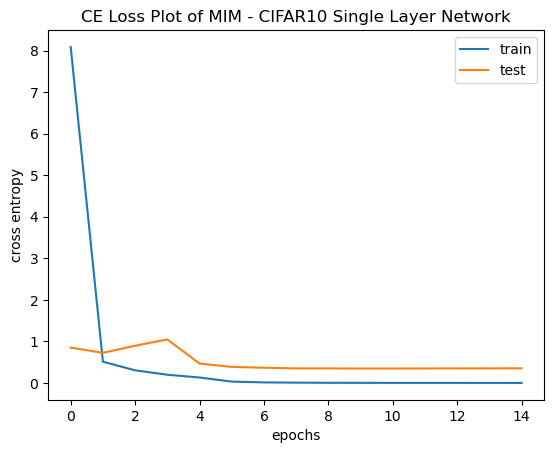

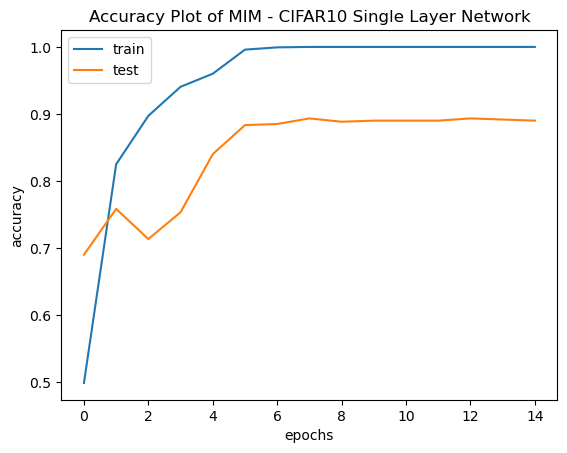

In [34]:
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.title("CE Loss Plot of MIM - CIFAR10 Single Layer Network")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy Plot of MIM - CIFAR10 Single Layer Network")
plt.legend()
plt.show()

Accuracy in training is continuosly improving as expected, whereas test accuracy kind of oscillates but improved. But CE Loss graph shows us that improving training performance might result with decrease in test performance as well. 

## 3.2 Downstream Task - TensorFlow Trainer Classification

In this part, we have used the *TensorFlow Trainer* module to train classification network. Architecture is similar to the previous model.

In [17]:
from tensorflow.keras import models, layers

tf_model = models.Sequential()

tf_model.add(layers.Dense(256, activation='relu', input_shape=(201728,)))

tf_model.add(layers.Dense(10, activation='softmax'))  

tf_model.summary()

C:\Users\anil.turgut\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │      51,642,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,645,194 (197.01 MB)

 Trainable params: 51,645,194 (197.01 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
tf_model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Optimizer and loss function is selected as *adam* and *SparseCategoricalCrossEntropy* to see whether there is any improvement in changing loss function.

In [19]:
history = tf_model.fit(copied_training_embeddings, train_labels, epochs=15,
                      validation_data = (copied_test_embeddings, test_labels))

Epoch 1/15


C:\Users\anil.turgut\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 392ms/step - accuracy: 0.3324 - loss: 49.4538 - val_accuracy: 0.6300 - val_loss: 1.2244
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 344ms/step - accuracy: 0.8623 - loss: 0.3808 - val_accuracy: 0.7617 - val_loss: 0.8813
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 341ms/step - accuracy: 0.9519 - loss: 0.1494 - val_accuracy: 0.8083 - val_loss: 0.7017
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 334ms/step - accuracy: 0.9127 - loss: 0.2613 - val_accuracy: 0.6733 - val_loss: 1.4658
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 336ms/step - accuracy: 0.9518 - loss: 0.1295 - val_accuracy: 0.8583 - val_loss: 0.5254
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 332ms/step - accuracy: 0.9958 - loss: 0.0116 - val_accuracy: 0.8667 - val_loss: 0.4806
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 338ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.8600 - val_loss: 0.4901
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 336ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.87

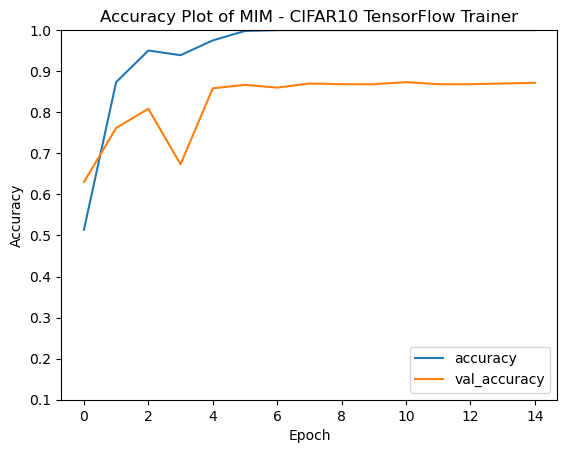

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy Plot of MIM - CIFAR10 TensorFlow Trainer")
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

Accuracy plot shows that the results of *TF Trainer* is better than *Single Layer Perceptron* models. We can cover almost 87% of the validation image dataset.

Let's finally analyze the *Support Vector Classifier (SVC)* model to analyze the results.

## 3.3 Downstream Task - Classification Using Support Vector Classifier (SVC)

In [21]:
from sklearn import svm

clf = svm.SVC(gamma='scale')

print(len(embeddings))

clf.fit(np.array(embeddings).reshape(-1, 201728), train_labels)

3000


C:\Users\anil.turgut\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [22]:
from socket import socket
# train metrics
y_pred_train_list = []

for embed in tqdm_note(embeddings):
    
    y_pred = clf.predict(np.array(embed).reshape(1, -1))
    y_pred_train_list.append(y_pred[0])


  0%|          | 0/3000 [00:00<?, ?it/s]

In [23]:
y_pred_test_list = []

for embed in tqdm_note(test_embeddings):
    
    y_pred = clf.predict(np.array(embed).reshape(1, -1))
    y_pred_test_list.append(y_pred[0])

  0%|          | 0/600 [00:00<?, ?it/s]

In [24]:
with open("CIFAR10Predictions/3000mimcifar10trainingpreds.json", "w") as f:
        f.write(json.dumps(np.array(y_pred_train_list).tolist()))

with open("CIFAR10Predictions/3000mimcifar10testpreds.json", "w") as f:
        f.write(json.dumps(np.array(y_pred_test_list).tolist()))

In [ ]:
y_pred_train_list
with open('CIFAR10Predictions/mimcifar10trainingpreds.json') as f:
    y_pred_train_list = json.load(f)
    
    
with open('CIFAR10Predictions/mimcifar10testpreds.json') as f:
    y_pred_test_list = json.load(f)

In [25]:
# Calculate evaluation metrics on the training data
accuracy_train = accuracy_score(train_labels, y_pred_train_list)
precision_train = precision_score(train_labels, y_pred_train_list, average='weighted')
recall_train = recall_score(train_labels, y_pred_train_list, average='weighted')
f1_train = f1_score(train_labels, y_pred_train_list, average='weighted')

print("Training Accuracy:", round(accuracy_train,6))
print("Training Precision:", round(precision_train,6))
print("Training Recall:", round(recall_train,6))
print("Training F1-score:", round(f1_train,6))

Training Accuracy: 0.177
Training Precision: 0.050938
Training Recall: 0.177
Training F1-score: 0.074596


C:\Users\anil.turgut\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, y_pred_test_list)
precision = precision_score(test_labels, y_pred_test_list, average='weighted')
recall = recall_score(test_labels, y_pred_test_list, average='weighted')
f1 = f1_score(test_labels, y_pred_test_list, average='weighted')

print("Test Accuracy:", round(accuracy,4))
print("Test Precision:", round(precision,4))
print("Test Recall:", round(recall,4))
print("Test F1-score:", round(f1,4))


Test Accuracy: 0.1583
Test Precision: 0.0444
Test Recall: 0.1583
Test F1-score: 0.0651


C:\Users\anil.turgut\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*SVC* performed very poorly on this embeddings, it might due to the dimension of the embeddings.

## 4.1 Testing Classifier Model Performance on Image from different Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


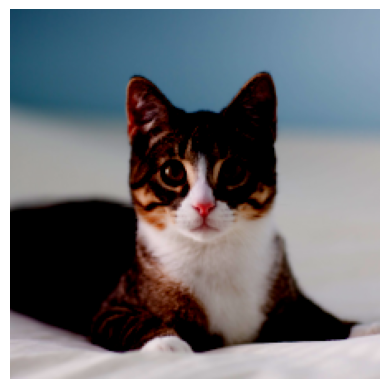

In [27]:
input_file =  "C:\\Users\\anil.turgut\\Desktop\\CMPE597\\Notebooks\\cat\\730d6a8791.jpg"

new_image = load_image(input_file)

plot_image(new_image)

In [ ]:
mim_mael16.to(device)

### 4.1.1 -  SVC

In [28]:
with torch.no_grad():
    embedding = mim_mael16(new_image.to(device))
    
    embedding = np.array(embedding[0].detach().cpu().numpy()).reshape(1, -1).tolist()
    
    embedding = torch.tensor(embedding, dtype=torch.float32)
    
    embedding.to(device)

    prediction = clf.predict(np.array(embedding).reshape(1, -1))

    print("Predicted class: " + class_names[prediction[0]])

C:\Users\anil.turgut\AppData\Local\anaconda3\Lib\site-packages\kappamodules\attention\dot_product_attention.py:69: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(q, k, v, attn_mask=attn_mask)


Predicted class: bird


### 4.1.2 -  Single Layer Torch Network

In [29]:
with torch.no_grad():
    
    model.eval()
    prediction = model(embedding)
    print("Prediction: ", prediction)
    max_value, index = torch.max(prediction, dim = 1)
    
    print("Predicted class: " + class_names[index])

Prediction:  tensor([[ 2.4777, -2.9203,  4.0638,  7.7736, -8.8447,  6.6481, -1.5074, -0.9019,
         -4.6798, -2.2973]])
Predicted class: cat


### 4.1.3 -  TF Trainer

In [30]:
prediction = tf_model.predict(embedding)

class_names[np.argmax(prediction, axis = 1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


'cat'

Single layer *Torch* and *TensorFlow Trainer* has successfully classified the image, where as *SVC* could not.

## 5. Results/Analysis

MIM-Refiner leverages multiple contrastive heads that are connected to diverse intermediate layers. In each head, a modified nearest neighbor objective helps to construct respective semantic clusters. In this notebook, we have analyzed ImageNet1k fed pretrained *MIM* model with the *CIFAR10* dataset. Image embeddings obtained from *MIM* model are used as an input to train 3 different classification model/networks as following: *Single Layer Network*, *TensorFlow Trainer* and *Support Vector Classifier*.

As mentioned before, within the scope of this study, we could not work with the entire CIFAR10 dataset because at this point, our local computers cannot store the relevant embeddings and even if they could, we do not have the hardware to train the models.

Neural network models (*Single Layer Net, TF Trainer*) perform sufficient performance on CIFAR10 *MIM* embeddings with almost 87% validation accuracy. However, SVC performed exteremely poorly on both training and test datasets. It might be the reason that since dimension of each embedding is significantly large and having not sufficient amount of training data. 

In terms of performance/memory of the algorithm analysis, *neural network classifiers* are more efficient than the *SVC* in terms of both speed and the memory usage.

## References

- https://www.cs.toronto.edu/~kriz/cifar.html
- https://github.com/ml-jku/MIM-Refiner
- https://arxiv.org/abs/2402.10093
- https://paperswithcode.com/sota/self-supervised-image-classification-on
- https://towardsdatascience.com/dino-emerging-properties-in-self-supervised-vision-transformers-summary-ab91df82cc3c
- https://arxiv.org/abs/2010.11929v2
- https://arxiv.org/abs/1706.03762
- https://paperswithcode.com/sota/self-supervised-image-classification-on